# LSTM close prediction

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dt
import fxcmpy

fxcmpy.__version__


'1.1.28'

# Conectarse con los precios

In [92]:
# Actualizar regularmente el software
# pip install fxcmpy --upgrade

#Definir el número
TOKEN = '343d993273bd7f779e4fdb7c7b9cbe01c3608e51'
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error')

In [93]:
instrument='USOil'
document_name='JPN225'
start = dt.datetime(2014, 10, 7)
stop = dt.datetime(2018, 10, 7)
data=con.get_candles(instrument, period='H4',
                start=start, stop=stop)
data.drop(data.columns[[0,1,2,3,4,8]], axis=1, inplace=True)

today = datetime.date.today()


file_name = document_name+'_currency_%s.csv' 
#data.to_csv(file_name)

data.tail()

,askclose,askhigh,asklow
date,,,
2018-10-05 06:00:00,74.925,74.965,74.730
2018-10-05 10:00:00,74.825,74.925,74.495
2018-10-05 14:00:00,74.795,75.030,74.020
2018-10-05 18:00:00,74.895,75.245,74.190
2018-10-05 20:00:00,74.385,74.420,74.315


In [55]:
iplot(data[['askhigh','asklow']].iplot(asFigure=True,title='Close'))

In [1]:
#data1=np.asmatrix(data)
#data1[:,0:1]
#data=pd.DataFrame(data.mean(axis=1))
#data.tail()

# Función para crear los datos de testing y normalizarlos

In [143]:
def load_data(stock, seq_len, porcentaje_de_datos):
    amount_of_features = len(stock.columns) # Este es el número de columnas que tienen los datos
    data = stock.as_matrix() #Vuelve los datos en una matriz de valores 
    sequence_length = seq_len + 1 # Crea el largo de la secuencia tomando el valor de la secuencia (seq_len) y le adiciona 1 
    result = [] # Crea un vector llamado resultados
    for index in range(len(data) - sequence_length): # Para cada indicen en el rango de los datos menos el largo de la secuencia
        result.append(data[index: index + sequence_length]) #En resultaddos agrega los datos desde desde 1 hasta el largo de
        # los datos menos la secuencia. Es decir crea un grupo de valores de la siguiente manera: 
        # de 1 hasta (1+len(data)-sequence_lenght), de 2 hasta (2+len(data)-sequence_lenght); y asi sucesivamente. Y los guarda en 
        # el vector de resultados 
    result = np.array(result) # Vuelve un array de los datos

    row = round(porcentaje_de_datos * result.shape[0]) # Me dice en número de filas que hay en la matriz de resultados y saca el.
    train = result[:int(row), :] # Crea una matriz para entrenda tomando de la matriz de resultados los valores desde el inicio
    #porcentaje fijado de la fila, hasta el porcentaje_de_datos del número de las filas (row)
    x_train = train[:,:-1] # Para los datos de x toma todos los valores de las filas y les quita la última columna
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1] # Los datos para hacer el test empizan desde el valor del 90% de los datos
    y_test = result[int(row):, -1][:,-1]
    print(x_train.shape)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features)) # Cambiar la forma de los datos
    # con el número filas(x_train.shape[0]), el npumero de columnas  (x_train.shape[1]), 
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [150]:
print(y_test)

[49.36 49.24 48.89 48.49 48.81 49.01 48.74 48.69 47.84 48.64 49.44 50.34
 50.44 50.6  50.39 48.5  49.01 48.91 49.14 49.15 48.83 49.59 49.21 48.73
 48.89 49.35 49.   49.04 48.69 49.99 50.59 50.26 50.74 50.96 51.24 51.54
 52.19 51.9  51.61 50.11 49.84 50.46 51.25 50.94 50.34 51.86 51.94 52.61
 53.16 53.06 53.01 50.84 51.21 53.04 52.96 52.7  52.76 52.56 52.14 52.54
 52.49 52.11 52.04 51.79 51.66 51.09 51.05 50.69 49.84 49.69 49.73 49.24
 49.16 48.79 48.11 48.84 49.49 50.21 50.36 49.89 49.96 51.34 51.94 52.04
 52.08 52.44 52.74 52.15 51.69 51.86 52.16 51.31 51.11 50.96 51.16 51.06
 50.76 50.21 50.   48.59 47.69 47.41 48.61 47.95 48.81 50.44 51.01 52.08
 51.8  51.56 50.64 50.39 49.91 49.81 49.75 49.04 47.95 47.99 46.86 46.78
 46.69 46.49 44.89 44.34 44.46 44.51 44.51 44.01 43.61 44.26 44.24 44.41
 44.35 44.09 44.56 45.06 45.19 45.41 45.36 45.58 45.21 44.96 44.84 44.91
 45.09 45.04 45.34 44.91 44.74 44.85 44.3  45.36 45.49 45.38 46.31 47.
 46.54 45.89 46.06 47.21 47.14 47.39 47.25 47.14 47.0

# Función del LSTM 

In [98]:
def build_model(layers): # El layer va a ser un vector de la manera [a,b,c] 
    model = Sequential() 

    model.add(LSTM(
        input_dim=layers[0], # acá se ponen la dimensión de los datos de entrada [a]. 
        output_dim=layers[1],# acá se ponen la dimensión de los datos de salida [b]
        return_sequences=True)) # La poner esto como verdadero significa que estos output
        #layers siempre se va a mandar al siguiente leyer 
    model.add(Dropout(0.2)) # se pone un 20% de dropout

    #Segundo layer: 
    model.add(LSTM(
        layers[2], # este es un LSTM con [c] unidades
        return_sequences=False)) 
    model.add(Dropout(0.2)) # Este no hace una predicción de la secuencia
    # si no una predicción del vectorpara toda la secuencia de inputs

    model.add(Dense(
        output_dim=layers[2])) # agrega los datos de la predicción del vector con [c] unidades
    # un solo valor 
    model.add(Activation("linear"))

    start = time.time()
    # Optimizar el modelo con mse y usa el optimizador rmsprop
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

# Trabajo con los datos y estructuración del modelo

In [158]:
# Parametros: 
window = 3 # Ventana de datos 
# División de datos
X_train, y_train, X_test, y_test = load_data(data[::-1], window,0.9)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)



(5445, 3, 3)
X_train (5445, 3, 3)
y_train (5445,)
X_test (605, 3, 3)
y_test (605,)


C:\Users\Conda\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



## Fijar semilla

In [159]:
np.random.seed(7)

# Cargar la secuencia estructural del modelo

In [160]:
# Parametros 
input_dimension=1
unit=1
# model = build_model([3,lag,1])
model = build_model2([3,window,1])

C:\Users\Conda\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`

C:\Users\Conda\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`



# Ejecutar el modelo y el RMS/RMSE results

In [161]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=0)

C:\Users\Conda\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



In [162]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.27 MSE (0.52 RMSE)
Test Score: 10.00 MSE (3.16 RMSE)


In [163]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

# Predictions vs Real results

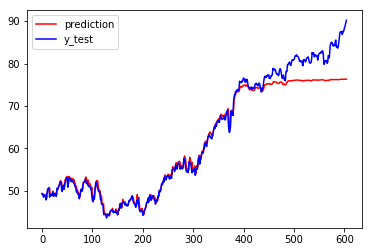

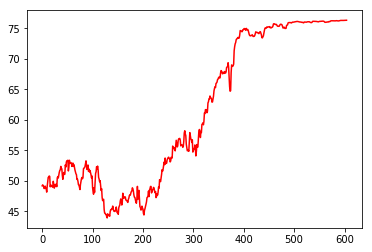

In [164]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()
plt2.plot(p,color='red', label='prediction')
plt2.show()

In [157]:
#Step 4 - Plot the predictions!
#predictions = lstm.predict_sequences_multiple(model, X_test, 5, 5)
#lstm.plot_results_multiple(predictions, y_test, 5)